In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import dlsim, butter, lfilter
import scienceplots

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

# Testbench parameters

The small-scale maritime thruster testbench was modelled using the shaft-line finite element method (FEM). In the shaft-line FEM, the system is modelled as lumped-elements with inertia, connected by torsional springs with stiffness and damping. Torque losses from the motors and gears were modelled as external damping.

In [3]:
def new_parameters():
    inertias = np.array([7.94e-4,
                         3.79e-6,
                         3.00e-6,
                         2.00e-6,
                         7.81e-3,
                         2.00e-6,
                         (3.17e-6 - 7800*(np.pi*(0.006**4)/32)*0.342/6) + 7800*(np.pi*(0.008**4)/32)*0.342/6,
                         5.01e-5,
                         6.50e-6,
                         5.65e-5,
                         4.27e-6,
                         3.25e-4,
                         1.20e-4,
                         1.15e-5,
                         1.32e-4,
                         4.27e-6,
                         2.69e-4,
                         1.80e-4,
                         2.00e-5,
                         2.00e-4,
                         4.27e-6,
                         4.95e-2])

    stiffnesses = np.array([1.90e5,
                            6.95e3,
                            90.00,
                            90.00,
                            90.00,
                            90.00,
                            80e9*(np.pi*(0.008**4)/32)/0.342,
                            4.19e4,
                            5.40e3,
                            4.19e4,
                            1.22e3,
                            4.33e4,
                            3.10e4,
                            1.14e3,
                            3.10e4,
                            1.22e4,
                            4.43e4,
                            1.38e5,
                            2.00e4,
                            1.38e5,
                            1.22e4])

    damping = np.array([8.08,
                        0.29,
                        0.24,
                        0.24,
                        0.24,
                        0.24,
                        0.00,
                        1.78,
                        0.23,
                        1.78,
                        0.52,
                        1.84,
                        1.32,
                        0.05,
                        1.32,
                        0.52,
                        1.88,
                        5.86,
                        0.85,
                        5.86,
                        0.52])


    external_damping = np.array([0.0030,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.0038,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.0038,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.2400])

    gear_ratios = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1/3, 1, 1, 1, 1, 1/4, 1, 1, 1, 1])

    return inertias, stiffnesses, damping, external_damping, gear_ratios


# State-space matrices

The state-space matrices are constructed the same way as in the master's thesis and the MSSP article.

In [4]:
def state_space_matrices(inertia, stiff, damp, damp_ext, ratios, full_B=False):
    """
    Parameters:
    
    inertia : list
        The inertia values of each lumped mass in order from index 1...n
    stiff : list
        The stiffness values between each lumped mass in order from index 1...n
    damp : list
        The viscous damping values between each lumped mass in order from index 1...n
    damp_ext : list
        The external damping corresponding to torque losses from the motors and gears
    ratios : list
        The gear ratios between each lumped mass
    full_B : bool
        If true, the input matrix B is shape n x p, allowing applying an input at the
        location of every lumped mass. By default it's shape is n x 2, for applying an input
        at the locations corresponding to the driving motor and the propeller. 
        
    Returns:
    
    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    D : numpy.ndarray
        The feedthrough matrix, always a zero matrix

    """
    cn = damp*ratios
    cn2 = damp*ratios**2
    cn2 = np.hstack((cn2, 0))
    c0 = np.copy(damp)
    c0 = np.insert(c0, 0, 0, axis=0)
    cn2d = -(c0 + cn2 + damp_ext)

    A11 = (np.diag(cn2d) + np.diag(cn, k=1) + np.diag(cn, k=-1)) / inertia.reshape(inertia.shape[0], 1)

    ks = -np.hstack((stiff*ratios, 0))
    A12 = np.delete(
        (np.diag(ks) + np.diag(stiff, k=-1)) / inertia.reshape(inertia.shape[0], 1), -1, axis=1
    )


    A23 = np.delete(
        np.diag(np.hstack((ratios, 0))) + np.diag(-np.ones(len(ratios)), k=1), -1, axis=0
    )

    A = np.vstack((np.hstack((A11, A12)), np.hstack((A23, np.zeros((A23.shape[0], A23.shape[1]-1))))))

    if full_B:
        B = np.zeros(A.shape)
        for i in range(len(inertia)):
            B[i,i] += 1/inertia[i]
    else:
        B = np.zeros((A.shape[0], 2))
        B[0,0] += 1/inertia[0]
        B[len(inertia)-1, 1] -= 1/inertia[-1]

    C = np.zeros((3, A.shape[0]))
    C[0,6] += 1
    C[1,7] += 1
    C[2,30] += 5400
    D = np.zeros((C.shape[0], B.shape[1]))

    return A, B, C, D

In [5]:
def c2d(A, B, ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time ts.
    The function returns matrices Ad, Bd of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]

    return Ad, Bd


# Data equation matrices

In [6]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))

    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O


def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)

    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B,
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z

        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))

        # then add the impulse responses
        A_power2 = np.copy(A)

        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))

        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))

        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1

    return gamma


def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)

    # delete incomplete rows
    D2 = D2[:-2*m, :]

    return D2


# Simulated impulse excitation

The same simulated input excitation as in the master's thesis.

In [7]:
# parameters for simulated excitations
fs = 1000  # sampling frequency
t_sim = np.arange(0,10,1/fs)  # timesteps
dt_sim = np.mean(np.diff(t_sim))  # timestep length

In [8]:
def impulse_excitation(sim_times, plot=False):
    """
    Parameters:
    
    sim_times : numpy.ndarray
        Timesteps of the simulation.
        
    Returns:
    
    U_imp : numpy.ndarray
        Input torque matrix. Rows correspond to timesteps, first column has the motor torque,
        second column has the propeller torque.
    """
    U_imp = np.zeros((len(sim_times), 2))

    e1 = np.random.normal(0, .01, U_imp.shape[0])
    e2 = np.random.normal(0, .01, U_imp.shape[0])

    one_hit = np.hstack((np.linspace(0, 0.34, 7), np.linspace(0.38, 0.64, 7), np.linspace(0.67, 0.87, 7), np.linspace(0.9, 0.98, 7)))

    U_imp[:,0] += 2.7 + e1
    U_imp[:,1] += e2
    U_imp[3200:3228,1] += one_hit*10
    U_imp[3228:3228+28,1] += np.flip(one_hit*10)
    U_imp[5200:5228,1] += one_hit*10
    U_imp[5228:5228+28,1] += np.flip(one_hit*10)
    U_imp[8200:8228,1] += one_hit*10
    U_imp[8228:8228+28,1] += np.flip(one_hit*10)

    if plot:
        plt.subplot(211)
        plt.plot(sim_times, U_imp[:,0], label='Driving motor setpoint', color='blue')
        plt.ylabel('Torque (Nm)')
        plt.legend()

        plt.subplot(212)
        plt.plot(sim_times, U_imp[:,1], label='Loading motor setpoint', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (Nm)')
        plt.legend()
        plt.tight_layout()

        plt.show()

    return U_imp

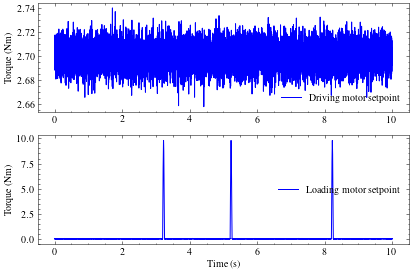

In [9]:
impulse_sim = impulse_excitation(t_sim, plot=True)

In [10]:
def step_excitation(sim_times, plot=False):
    """
    Parameters:
    
    sim_times : numpy.ndarray
        Timesteps of the simulation.
        
    Returns:
    
    U_step : numpy.ndarray
        Input torque matrix. Rows correspond to timesteps, first column has the motor torque,
        second column has the propeller torque.
    """
    U_step = np.zeros((len(sim_times), 2))

    e1 = np.random.normal(0, .01, U_step.shape[0])
    e2 = np.random.normal(0, .01, U_step.shape[0])

    # U_step[:,0] += np.flip(np.linspace(-2.5, 2.5, 10000)) + e1
    U_step[:,0] += 2.7 + e1
    U_step[:,1] += e2
    U_step[3200:5200,1] += 10.0
    U_step[5200:8200,1] -= 4.0
    U_step[8200:,1] += 0.5

    if plot:
        plt.subplot(211)
        plt.plot(sim_times, U_step[:,0], label='Driving motor setpoint', color='blue')
        plt.ylabel('Torque (Nm)')
        plt.legend()

        plt.subplot(212)
        plt.plot(sim_times, U_step[:,1], label='Loading motor setpoint', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (Nm)')
        plt.legend()
        plt.tight_layout()

        plt.show()

    return U_step

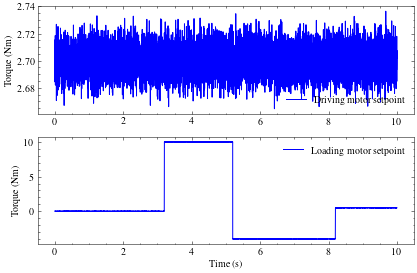

In [11]:
step_sim = step_excitation(t_sim, plot=True)

In [12]:
def sinusoidal_excitation(sim_times, plot=False):
    """
    Parameters:
    
    sim_times : numpy.ndarray
        Timesteps of the simulation.
        
    Returns:
    
    U_sin : numpy.ndarray
        Input torque matrix. Rows correspond to timesteps, first column has the motor torque,
        second column has the propeller torque.
    """

    def sum_sines(freqs, amps, phases, times, dc_offset):
        """
        Generates a sinusoidal signal that is a sum of three sine waves with different frequencies.

        Args:
        freqs (list[float]): List of three frequencies for the sine waves.
        amps (list[float]): List of three amplitudes for the sine waves.
        phases (list[float]): List of three phase shifts for the sine waves.
        times (numpy.ndarray): Timesteps of the signal in seconds.

        Returns:
        numpy.ndarray: Sinusoidal signal that is a sum of three sine waves.
        """

        signal = np.zeros(len(times))
        for f, a, p in zip(freqs, amps, phases):
            signal += a * np.sin(2 * np.pi * f * times + p)

        return signal + dc_offset

    freqs = [2000/60*2*np.pi, 4*2000/60*2*np.pi, 8*2000/60*2*np.pi]
    amps = [10, 5, 1]
    phases = [0, 0, 0]
    offset = 10
    sine_signal = sum_sines(freqs, amps, phases, sim_times, offset)

    U_sin = np.zeros((len(sim_times), 2))

    e1 = np.random.normal(0, .01, U_sin.shape[0])
    e2 = np.random.normal(0, .01, U_sin.shape[0])

    U_sin[:,0] += 2.7 + e1
    U_sin[:,1] += sine_signal + e2

    if plot:
        plt.subplot(211)
        plt.plot(sim_times, U_sin[:,0], label='Driving motor setpoint', color='blue')
        plt.ylabel('Torque (Nm)')
        plt.legend()

        plt.subplot(212)
        plt.plot(sim_times, U_sin[:,1], label='Loading motor setpoint', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (Nm)')
        plt.legend()
        plt.tight_layout()

        plt.show()

    return U_sin

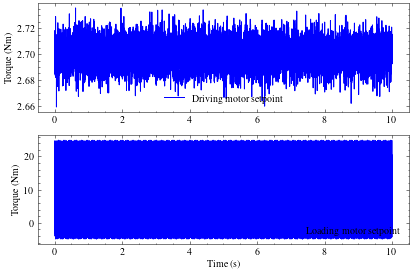

In [13]:
sin_sim = sinusoidal_excitation(t_sim, plot=True)

# Get excitation and measurement data

This dataset was used in the master's thesis for the excitation experiments on the testbench. Sampling frequency ~1 kHz. The data has been low pass filtered with a cutoff frequency of 500 Hz.

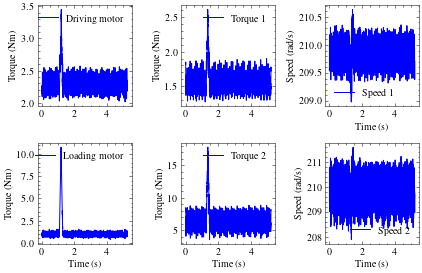

In [14]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_imp = np.loadtxt("../data/masters_data/processed_data/impulse_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_imp = np.loadtxt("../data/masters_data/processed_data/impulse_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_imp[:,0], motor_data_imp[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_imp[:,0], motor_data_imp[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

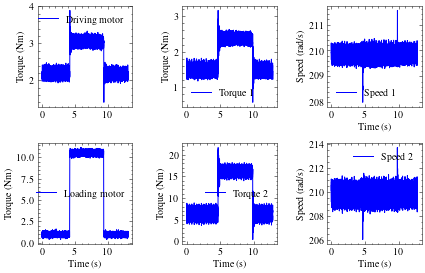

In [15]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_step = np.loadtxt("../data/masters_data/processed_data/step_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_step = np.loadtxt("../data/masters_data/processed_data/step_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_step[:,0], motor_data_step[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_step[:,0], motor_data_step[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

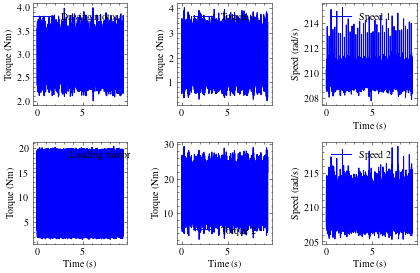

In [16]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_sin = np.loadtxt("../data/masters_data/processed_data/sin_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_sin = np.loadtxt("../data/masters_data/processed_data/sin_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_sin[:,0], motor_data_sin[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_sin[:,0], motor_data_sin[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_sin[:,0], sensor_data_sin[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_sin[:,0], sensor_data_sin[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_sin[:,0], sensor_data_sin[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_sin[:,0], sensor_data_sin[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data = np.loadtxt("../data/masters_data/processed_data/ice_2000_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data = np.loadtxt("../data/masters_data/processed_data/ice_2000_sensor.csv", delimiter=",")

In [18]:
time = sensor_data[:,0]
measurements = sensor_data[:,1:] # measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
motors = np.vstack((motor_data[:,2], motor_data[:,4])).T # motor torque data

In [19]:
motor_setpoint = motor_data[:,1]
propeller_setpoint = motor_data[:,3]

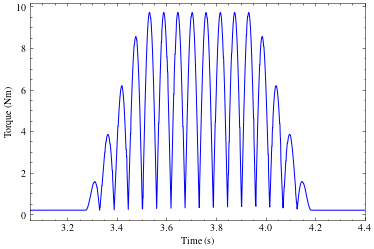

In [20]:
plt.plot(time, propeller_setpoint, c='b')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.xlim(3.05,4.4)
plt.savefig("notebook_figures/propeller_setpoint.pdf")

In [21]:
motor = motors[:,0]
propeller = motors[:,-1]

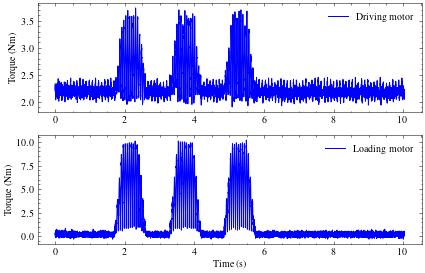

In [22]:
plt.subplot(211)
plt.plot(time, motor, label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(212)
plt.plot(time, propeller, label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.tight_layout()

plt.show()

# Initiate the input and state estimation procedure

In [23]:
def get_testbench_state_space(dt):
    """
    This function returns the discrete-time state-space matrices of the testbench model.
    """
    inertias, stiffs, damps, damps_ext, ratios = new_parameters()
    Ac, Bc, C, D = state_space_matrices(inertias, stiffs, damps, damps_ext, ratios)

    A, B = c2d(Ac, Bc, dt)

    return A, B, C, D

In [24]:
dt = np.mean(np.diff(time))
A, B, C, D = get_testbench_state_space(dt)
ss = (A, B, C, D)

In [25]:
# include second torque transducer to the observation matrix
C_mod = np.insert(C, 3, np.zeros((1, C.shape[1])), 0)
C_mod[3,22+18] += 2e4
D_mod = np.zeros((C_mod.shape[0], B.shape[1]))

# Analytical solution of the $\ell_2$ regularized LS problem

In [26]:
def progressbar(it, prefix="", size=60, out=sys.stdout, show_print=False):
    """
    A function used to display a progress bar in the console.
    """
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count}", end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    if show_print:
        print("\n", flush=True, file=out)

In [27]:
def get_data_equation_matrices(A, B, C, D, n, bs):
    D2 = second_difference_matrix(bs, B.shape[1])
    O_mat = O(A, C, bs)
    G = gamma(A, B, C, bs)
    L = np.eye(bs*B.shape[1])

    return O_mat, G, D2, L

In [28]:
def ell2_analytical(ss, measurements, batch_size, overlap, times, lam=0.1, use_trend_filter=False, print_bar=True):

    dt = np.mean(np.diff(times))
    n = len(times)
    bs = batch_size + 2*overlap
    loop_len = int(n/batch_size)

    A, B, C, D = ss  # state space model
    O_mat, G, D2, L = get_data_equation_matrices(A, B, C, D, n, bs)  # data equation matrices

    if use_trend_filter:
        regul_matrix = D2 # regularization matrix
    else:
        regul_matrix = L

    H = np.hstack([O_mat, G])  # extended observation and impulse response matrix
    M = np.hstack([np.zeros((regul_matrix.shape[0], O_mat.shape[1])), regul_matrix])  # extended regularization matrix
    
    input_estimates = []

    for i in progressbar(range(loop_len), "Calculating estimates: ", loop_len, show_print=print_bar):
        if i == 0:
            batch = measurements[:bs,:]
        elif i == loop_len-1:
            batch = np.zeros((bs, measurements.shape[1]))
            # zero padding to finish estimation loop correctly
        else:
            batch = measurements[i*batch_size-overlap:(i+1)*batch_size+overlap,:]

        y = batch.reshape(-1,1)

        estimate = LA.inv(H.T @ H + lam*(M.T @ M)) @ H.T @ y

        input_estimates.append(estimate)

    return input_estimates


# L-curve using the simulated impulse excitation

The L-curve calculated using $ u = \left( \Gamma^T \Gamma + \lambda L^TL \right)^{-1} \Gamma^T y $, and plotting the residual norm and the $\ell_2$-norm on a log-log plot.

In [29]:
def L_curve(ss, measurements, times, lambdas, use_trend=False):
    dt = np.mean(np.diff(times))
    batch_size = len(times)
    overlap = 0
    n = len(times)

    A, B, C, D = ss
    O_mat, G, D2, L = get_data_equation_matrices(A, B, C, D, n, batch_size)

    if use_trend:
        regularization = D2
    else:
        regularization = L

    input_estimates = []

    y = measurements.reshape(-1,1)

    for i in progressbar(range(len(lambdas)), "Calculating estimates :", len(lambdas)):
        estimates = LA.inv(G.T @ G + lambdas[i]*(regularization.T @ regularization)) @ G.T @ y
        input_estimates.append(estimates)

    norm, res_norm = [], []
    for i in range(len(lambdas)):
        res_norm.append(np.linalg.norm(y - G @ input_estimates[i]))
        norm.append(np.linalg.norm(regularization @ input_estimates[i]))

    return norm, res_norm

In [30]:
#def calculate_curvature(lambdas, l_norms, res_norms):
#    kappas = []
#    for i in range(len(lambdas)):
#        eta = l_norms[i]**2
#        rho = res_norms[i]**2
#        eta_dot = 
#        rho_dot = -lambdas[i]**2*eta_dot
#        k = 2*(eta*rho)/eta_dot * (lambdas[i]**2*eta_dot*rho+2*lambdas[i]*eta*rho+lambdas[i]**4*eta*eta_dot)/(lambdas[i]**2*eta**2+rho**2)**(3/2)
#        kappas.append(k)
    
#    return kappas

In [31]:
def calculate_L_curve(times, dt, load, lambdas, use_trend=False, show_plot=False):
    A, B, C, D = get_testbench_state_space(dt)
    sys = (A, B, C, D)

    tout, yout, _ = dlsim((A, B, C, D, dt), u=load, t=times)
    e3 = np.random.normal(0, .1, yout.shape)
    y_noise = yout + e3

    l_norm, residual_norm = L_curve(
        sys,
        y_noise,
        tout,
        lambdas,
        use_trend=use_trend
    )

    if show_plot:
        plt.yscale("log")
        plt.xscale("log")
        plt.plot(residual_norm, l_norm, color='blue')
        plt.scatter(residual_norm, l_norm, color='blue')
        plt.xlabel("$||y-\Gamma u||_2$")
        plt.ylabel("$||L u||_2$")
        #plt.grid(which="both")
        #plt.tight_layout()
        plt.savefig("notebook_figures/impulse_hp_lcurve.eps")
        plt.show()

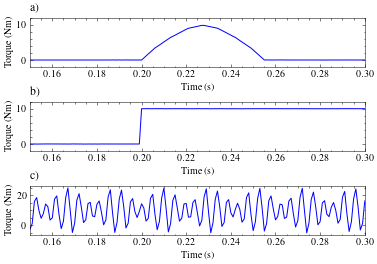

In [32]:
# taking a 500 timestep long section of the simulated excitation
excitation_sim = impulse_sim[3000:3500]
excitation_sim2 = step_sim[3000:3500]
excitation_sim3 = sin_sim[3000:3500]

t_sim_short = t_sim[:500]
plt.subplot(311)
plt.title("a)", loc='left')
plt.plot(t_sim_short, excitation_sim[:,1], c='b')
plt.xlim(0.15, 0.3)
plt.ylim(-2, 12)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.subplot(312)
plt.title("b)", loc='left')
plt.plot(t_sim_short, excitation_sim2[:,1], c='b')
plt.xlim(0.15, 0.3)
plt.ylim(-2, 12)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.subplot(313)
plt.title("c)", loc='left')
plt.plot(t_sim_short, excitation_sim3[:,1], c='b')
plt.xlim(0.15, 0.3)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
#plt.tight_layout(pad=0.5)
plt.subplots_adjust(hspace=0.7)
plt.savefig("notebook_figures/simulated_unit_excitations.eps")

In [33]:
# Regularization parameters for the calculation of the L-curve
regularization_parameters = np.logspace(-6, 6, 13)
print("Lambda values: ", regularization_parameters)

Lambda values:  [      0.           0.           0.0001       0.001        0.01
       0.1          1.          10.         100.        1000.
   10000.      100000.     1000000.    ]


### Simulated impulse L-curve

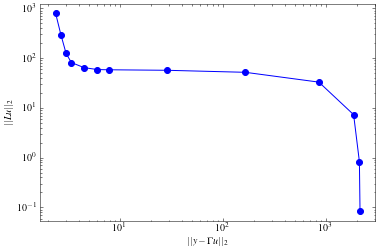

In [34]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim, regularization_parameters, use_trend=False, show_plot=True)

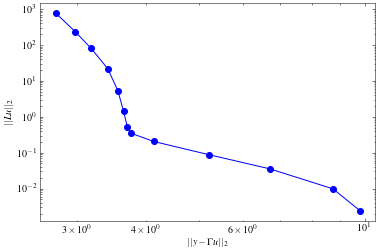

In [35]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim, regularization_parameters, use_trend=True, show_plot=True)

### Simulated step L-curve

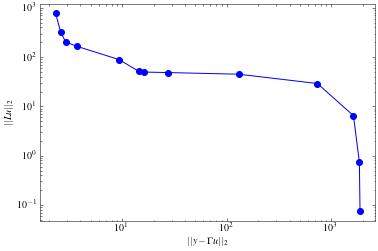

In [36]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim2, regularization_parameters, use_trend=False, show_plot=True)

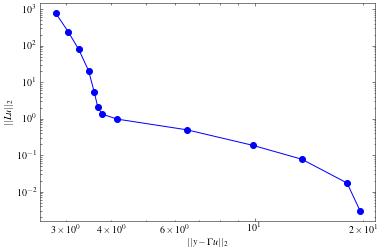

In [37]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim2, regularization_parameters, use_trend=True, show_plot=True)

### Simulated sin L-curve

Note: The L-curve criterion practically means choosing $\lambda$ at the corner of the L-curve as the regularization parameter. A mathematical definition for the corner exists, where the corner is found by calculating the curvature $\kappa$ of the L-curve. The pareto-optimal $\lambda$ is found where $\kappa$ is the largest. In this case, as is shown by the shape of the L-curve of the simulated sinusoidal excitation below, relying on $\kappa$ might not give the best value for $\lambda$.

In the present application, it might be beneficial to choose $\lambda$ qualitatively from the L-curve plot, especially as the user might want to utilize different values $\lambda$ to affect how strong the regularization is during torque estimation.

One option could be to first calculate a rough L-curve using a large range of values $\lambda$ and then concentrate on a smaller section of the L-curve, where the curvature $\kappa$ is calculated and a pareto-optimal $\lambda$ is found. However, whether solving a very precise value for $\lambda$ is necessary in this application is unclear.

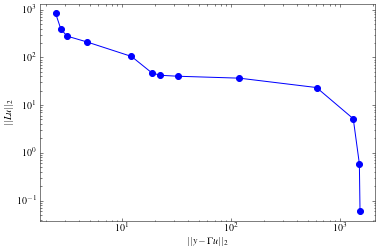

In [38]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim3, regularization_parameters, use_trend=False, show_plot=True)

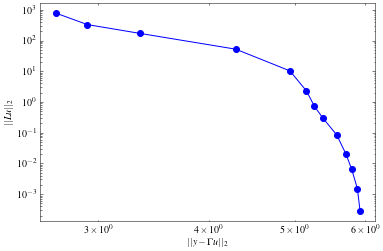

In [39]:
%matplotlib inline
calculate_L_curve(t_sim_short, dt_sim, excitation_sim3, regularization_parameters, use_trend=True, show_plot=True)

In [40]:
# parameters for the input and state estimation
batch_size = 500
overlap = 100

In [41]:
# lambda values for the different excitations
lam_tikh_imp = 0.001 # 0.01
lam_hp_imp = 1 # 10
lam_tikh_step = 0.1
lam_hp_step = 1
lam_tikh_sin = 0.1
lam_hp_sin = 10
lam_tikh_ice = 0.1
lam_hp_ice = 1

### Simulated unit excitation estimation

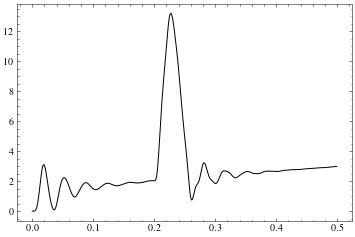

In [42]:
tout_sim_imp, yout_sim_imp, _ = dlsim((A, B, C_mod, D_mod, dt), excitation_sim, t=t_sim_short)
tout_sim_step, yout_sim_step, _ = dlsim((A, B, C_mod, D_mod, dt), excitation_sim2, t=t_sim_short)
tout_sim_sin, yout_sim_sin, _ = dlsim((A, B, C_mod, D_mod, dt), excitation_sim3, t=t_sim_short)

plt.plot(tout_sim_imp, yout_sim_imp[:,-1])

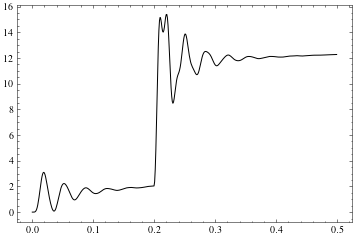

In [43]:
plt.plot(tout_sim_step, yout_sim_step[:,-1])

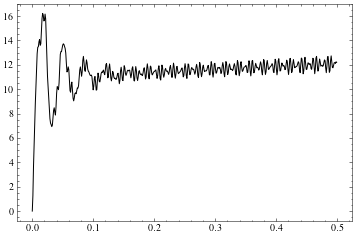

In [44]:
plt.plot(tout_sim_sin, yout_sim_sin[:,-1])

In [45]:
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_sim_imp = yout_sim_imp[:,:-1] + np.random.normal(0, .1, yout_sim_imp[:,:-1].shape)
print(measurements_sim_imp.shape)
lam_imp = lam_hp_imp
estimates_imp_sim = ell2_analytical(
    ss, measurements_sim_imp, batch_size, 0, t_sim_short, lam=lam_imp, use_trend_filter=True
)

(501, 3)
Calculating estimates: [█] 1/1



### Unit excitation experiments: input estimation

In [46]:
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_imp = sensor_data_imp[:,1:]
time_imp = sensor_data_imp[:measurements_imp.shape[0],0]
lam_imp = lam_hp_imp
estimates_imp = ell2_analytical(
    ss, measurements_imp[:,:3], batch_size, overlap, time_imp, lam=lam_imp, use_trend_filter=True
)

Calculating estimates: [██████████] 10/10



In [47]:
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_step = sensor_data_step[:,1:]
time_step = sensor_data_step[:measurements_step.shape[0],0]
lam_step = lam_hp_step
estimates_step = ell2_analytical(
    ss, measurements_step[:,:3], batch_size, overlap, time_step, lam=lam_step, use_trend_filter=True
)

Calculating estimates: [█████████████████████████] 25/25



In [48]:
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_sin = sensor_data_sin[:,1:]
time_sin = sensor_data_sin[:measurements_sin.shape[0],0]
lam_sin = lam_hp_sin
estimates_sin = ell2_analytical(
    ss, measurements_sin[:,:3], batch_size, overlap, time_sin, lam=lam_sin, use_trend_filter=True
)

Calculating estimates: [██████████████████] 18/18



### Ice excitation experiment: input estimation

In [49]:
# call the estimation function
times = time[:measurements.shape[0]]
lam = lam_hp_ice
estimates_ice = ell2_analytical(ss, measurements[:,:3], batch_size, overlap, times, lam=lam, use_trend_filter=True)

Calculating estimates: [████████████████████] 20/20



In [50]:
n_batches_imp = 10
n_batches_step = 25
n_batches_sin = 18
n_batches_ice = 20

In [51]:
def process_estimates(n_batches, overlap, estimates):
    # Here the input and initial state estimates are processed.
    # Overlapped sections are discarded and the input estimate batches are stacked one after the other.
    motor_estimates, propeller_estimates = [], []
    motor_est_overlap, prop_est_overlap = [], []
    for i in range(n_batches):
        if i == 0:
            all_motor_estimates = estimates[i][43::2]
            motor_est_overlap.append(all_motor_estimates)
            motor_estimates = all_motor_estimates[:-2*overlap]
            all_propeller_estimates = estimates[i][(43+1)::2]
            prop_est_overlap.append(all_propeller_estimates)
            propeller_estimates = all_propeller_estimates[:-2*overlap]
        else:
            all_motor_estimates = estimates[i][43::2]
            motor_est_overlap.append(all_motor_estimates)
            motor_estimates = np.concatenate(
                (motor_estimates, all_motor_estimates[overlap:-overlap])
            )
            all_propeller_estimates = estimates[i][(43+1)::2]
            prop_est_overlap.append(all_propeller_estimates)
            propeller_estimates = np.concatenate(
                (propeller_estimates, all_propeller_estimates[overlap:-overlap])
            )
    
    return motor_estimates, propeller_estimates

### Process and plot simulated estimates

In [52]:
motor_estimates_imp_sim, propeller_estimates_imp_sim = estimates_imp_sim[0][43::2], estimates_imp_sim[0][44::2]

In [53]:
U_est_imp_sim = np.hstack((motor_estimates_imp_sim, propeller_estimates_imp_sim))

In [54]:
tout_imp_sim, yout_imp_sim, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_imp_sim, t=t_sim_short)

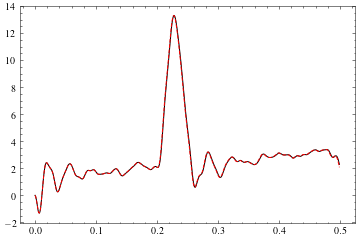

In [55]:
plt.plot(t_sim_short, yout_imp_sim[:-1,-1])
plt.plot(tout_imp_sim, yout_imp_sim[:,-1])

### Process and plot unit excitation experiment estimates

In [56]:
motor_estimates_imp, propeller_estimates_imp = process_estimates(n_batches_imp, overlap, estimates_imp)

In [57]:
U_est_imp = np.hstack((motor_estimates_imp, propeller_estimates_imp))  # Excitation matrix using estimated input torques 

In [58]:
print(U_est_imp.shape)
print(time_imp[:-234].shape)

(5000, 2)
(5000,)


In [59]:
# The testbench is simulated using the estimated input torques, with zero initial state.
tout_imp, yout_imp, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_imp, t=time_imp[:-234])

In [60]:
motor_estimates_step, propeller_estimates_step = process_estimates(n_batches_step, overlap, estimates_step)

In [61]:
U_est_step = np.hstack((motor_estimates_step, propeller_estimates_step))  # Excitation matrix using estimated input torques 

In [62]:
print(U_est_step.shape)
print(time_step.shape)

(12500, 2)
(12867,)


In [63]:
# The testbench is simulated using the estimated input torques, with zero initial state.
tout_step, yout_step, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_step, t=time_step[:-367])

In [64]:
motor_estimates_sin, propeller_estimates_sin = process_estimates(n_batches_sin, overlap, estimates_sin)

In [65]:
U_est_sin = np.hstack((motor_estimates_sin, propeller_estimates_sin))  # Excitation matrix using estimated input torques 

In [66]:
print(U_est_sin.shape)
print(time_sin.shape)

(9000, 2)
(9400,)


In [67]:
# The testbench is simulated using the estimated input torques, with zero initial state.
tout_sin, yout_sin, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_sin, t=time_sin[:-400])

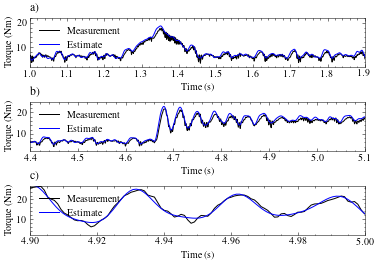

In [68]:
plt.subplot(311)
plt.title("a)", loc='left')
plt.plot(time_imp, measurements_imp[:,-1], c='black', label="Measurement")
plt.plot(tout_imp, yout_imp[:,-1], '-', c='b', label="Estimate")
plt.legend()
plt.xlim(1.,1.9)
plt.ylim(2,22)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.subplot(312)
plt.title("b)", loc='left')
plt.plot(time_step, measurements_step[:,-1], c='black', label="Measurement")
plt.plot(tout_step, yout_step[:,-1], '-', c='b', label="Estimate")
plt.legend()
plt.xlim(4.4,5.1)
plt.ylim(2,25)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.subplot(313)
plt.title("c)", loc='left')
plt.plot(time_sin, measurements_sin[:,-1], c='black', label="Measurement")
plt.plot(tout_sin, yout_sin[:,-1], '-', c='b', label="Estimate")
plt.legend()
plt.xlim(4.9,5.)
plt.ylim(2,27)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.subplots_adjust(hspace=0.7)
plt.savefig("notebook_figures/unit_experiment.eps")

In [69]:
motor_estimates_ice, propeller_estimates_ice = process_estimates(n_batches_ice, overlap, estimates_ice)

In [70]:
U_est = np.hstack((motor_estimates_ice, propeller_estimates_ice))  # Excitation matrix using estimated input torques 

In [71]:
# The testbench is simulated using the estimated input torques, with zero initial state.
tout, yout, xout = dlsim((A, B, C_mod, D_mod, dt), U_est, t=times[:-67])

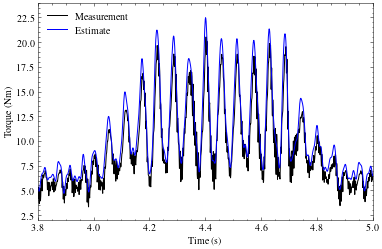

In [72]:
# plt.title("Torque sensor 2")
plt.plot(times, measurements[:,-1], c='black', label="Measurement")
plt.plot(tout, yout[:,-1], '-', c='b', label="Estimate")
plt.legend()
plt.xlim(3.8,5.)
plt.ylim(2,24)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.savefig("notebook_figures/l2_lam001.pdf")